In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload() #upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kavinduhandapangoda","key":"16f6e6baf751f0296cb3d5c405a8ab22"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d sukhandeepshergill/iamdatasethtrwords

100% 780M/782M [00:38<00:00, 25.3MB/s]
100% 782M/782M [00:38<00:00, 21.2MB/s]


In [5]:
from zipfile import ZipFile
file_name = "iamdatasethtrwords.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [6]:
!pip install keras_tqdm

In [7]:
import numpy as np
import cv2
import os
import pandas as pd
import string
import matplotlib.pyplot as plt

import os
from google.colab import drive #To use googel drive to get files.

from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional, Flatten
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras_tqdm import TQDMNotebookCallback

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [8]:
import tensorflow as tf

#ignore warnings in the output
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [9]:
from tensorflow.python.client import device_lib

# Check all available devices if GPU is available
print(device_lib.list_local_devices())
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10403064443007972343
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15898275988159849275
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [10]:
tf.config.experimental.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [11]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [12]:
#drive.mount('/content/gdrive')
with open('./words.txt') as f:
    contents = f.readlines()

lines = [line.strip() for line in contents]
lines[0]

'a01-000u-00-00 ok 154 408 768 27 51 AT A'

In [13]:
max_label_len = 0

char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"


print(char_list, len(char_list))

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(char_list.index(chara))

    return dig_lst

!"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 78


In [14]:
images = []
labels = []

RECORDS_COUNT = 10000

In [15]:
train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

inputs_length = []
labels_length = []

In [16]:
def process_image(img):
    """
    Converts image to shape (32, 128, 1) & normalize
    """
    w, h = img.shape

#     _, img = cv2.threshold(img,
#                            128,
#                            255,
#                            cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # Aspect Ratio Calculation
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape

    img = img.astype('float32')

    # Converts each to (32, 128, 1)
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape

    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape

    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)

    img = cv2.subtract(255, img)

    img = np.expand_dims(img, axis=2)

    # Normalize
    img = img / 255

    return img

In [17]:
import tarfile
import os

# Define the path to your .tgz file
file_path = "./words.tgz"

# Define the directory where you want to extract the contents
extract_dir = "words"

# Create the extraction directory if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Open the .tgz file
with tarfile.open(file_path, "r:gz") as tar:
    # Extract all contents to the extraction directory
    tar.extractall(path=extract_dir)

print("Extraction complete.")


Extraction complete.


In [18]:
for index, line in enumerate(lines):
    splits = line.split(' ')
    status = splits[1]

    if status == 'ok':
        word_id = splits[0]
        word = "".join(splits[8:])

        splits_id = word_id.split('-')
        filepath = 'words/{}/{}-{}/{}.png'.format(splits_id[0],
                                                  splits_id[0],
                                                  splits_id[1],
                                                  word_id)

        # processing on image
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = process_image(img)
        except:
            continue

        # processing on label
        try:
            label = encode_to_labels(word)
        except:
            continue

        if index % 10 == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(31)
            valid_label_length.append(len(word))
            valid_original_text.append(word)
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))
            train_original_text.append(word)

        if len(word) > max_label_len:
            max_label_len = len(word)

    if index >= RECORDS_COUNT:
        break

In [19]:
train_padded_label = pad_sequences(train_labels,
                             maxlen=max_label_len,
                             padding='post',
                             value=len(char_list))

valid_padded_label = pad_sequences(valid_labels,
                             maxlen=max_label_len,
                             padding='post',
                             value=len(char_list))

In [20]:
train_padded_label.shape, valid_padded_label.shape

((7850, 16), (876, 16))

In [21]:

train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

In [22]:
train_images.shape

(7850, 32, 128, 1)

In [23]:
# input with shape of height=32 and width=128
inputs = Input(shape=(32,128,1))

# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)

conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)

# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)

# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)

conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)

squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)

outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [24]:
act_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 32, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 32, 256)        295168

In [25]:
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args

    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

In [26]:
batch_size = 8
epochs = 30
e = str(epochs)
optimizer_name = 'sgd'

In [27]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])

filepath="./HTR_Using_CRNN/Model/{}o-{}r-{}e-{}t-{}v.hdf5".format(optimizer_name,
                                          str(RECORDS_COUNT),
                                          str(epochs),
                                          str(train_images.shape[0]),
                                          str(valid_images.shape[0]))

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [28]:
history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=2,
                    callbacks=callbacks_list)

Epoch 1/30

Epoch 1: val_loss improved from inf to 14.64880, saving model to ./HTR_Using_CRNN/Model/sgdo-10000r-30e-7850t-876v.hdf5
982/982 - 43s - loss: 15.4757 - accuracy: 0.0000e+00 - val_loss: 14.6488 - val_accuracy: 0.0000e+00 - 43s/epoch - 44ms/step
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 14.64880 to 14.35183, saving model to ./HTR_Using_CRNN/Model/sgdo-10000r-30e-7850t-876v.hdf5
982/982 - 25s - loss: 12.8727 - accuracy: 0.0172 - val_loss: 14.3518 - val_accuracy: 0.0080 - 25s/epoch - 26ms/step
Epoch 3/30

Epoch 3: val_loss improved from 14.35183 to 11.32054, saving model to ./HTR_Using_CRNN/Model/sgdo-10000r-30e-7850t-876v.hdf5
982/982 - 28s - loss: 11.1525 - accuracy: 0.0590 - val_loss: 11.3205 - val_accuracy: 0.0651 - 28s/epoch - 28ms/step
Epoch 4/30

Epoch 4: val_loss did not improve from 11.32054
982/982 - 26s - loss: 9.3984 - accuracy: 0.0973 - val_loss: 12.1488 - val_accuracy: 0.0662 - 26s/epoch - 27ms/step
Epoch 5/30

Epoch 5: val_loss improved from 11.32054 to 8.30294, saving model to ./HTR_Using_CRNN/Model/sgdo-10000r-30e-7850t-876v.hdf5
982/982 - 25s - loss: 7.5967 - accuracy: 0.1425 - val_loss: 8.3029 - val_accuracy: 0.1290 - 25s/epoch - 26ms/step
Epoch 6/30

Epoch 6: val_loss did not improve from 8.30294
982/982 - 25s - loss:

In [29]:
!pip install python-levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 81.7 MB/s eta 0:00:00


In [30]:
# load the saved best model weights
act_model.load_weights(filepath)

# predict outputs on validation images
prediction = act_model.predict(valid_images)

28/28 [==============================] - 4s 40ms/step


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Select the first 100 samples from the validation set
limited_valid_images = valid_images[:50]
limited_valid_labels = valid_labels[:50]

# Predict outputs on limited validation images
predictions = act_model.predict(limited_valid_images)

# Use CTC decoder
decoded = K.ctc_decode(predictions,
                       input_length=np.ones(predictions.shape[0]) * predictions.shape[1],
                       greedy=True)[0][0]
decoded_labels = [''.join([char_list[int(p)] for p in x if p != -1]) for x in decoded]

# Convert original labels to strings
true_labels = [''.join([char_list[int(p)] for p in label if p != -1]) for label in limited_valid_labels]

# Construct confusion matrix
conf_matrix = confusion_matrix(true_labels, decoded_labels)

# Visualize confusion matrix
plt.figure(figsize=(15, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=decoded_labels, yticklabels=true_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [35]:
# load the saved best model weights
act_model.load_weights(filepath)

# predict outputs on validation images
prediction = act_model.predict(valid_images)

# use CTC decoder
decoded = K.ctc_decode(prediction,
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]
out = K.get_value(decoded)

import Levenshtein as lv

total_jaro = 0
total_rati = 0
# see the results
for i, x in enumerate(out):
    letters=''
    for p in x:
        if int(p) != -1:
            letters+=char_list[int(p)]
    total_jaro+=lv.jaro(letters, valid_original_text[i])
    total_rati+=lv.ratio(letters, valid_original_text[i])

print('jaro :', total_jaro/len(out))
print('ratio:', total_rati/len(out))

28/28 [==============================] - 0s 16ms/step
jaro : 0.9201326694192005
ratio: 0.8905403483815185


**Prediction.**

In [ ]:
# predict outputs on validation images
prediction =act_model.predict(train_images[542:645])

# use CTC decoder
decoded = K.ctc_decode(prediction,
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)

# see the results
for i, x in enumerate(out):
    print("original_text =  ", train_original_text[542+i])
    print("predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end = '')
    plt.imshow(train_images[542+i].reshape(32,128), cmap=plt.cm.gray)
    plt.show()
    print('\n')

In [37]:
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [38]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

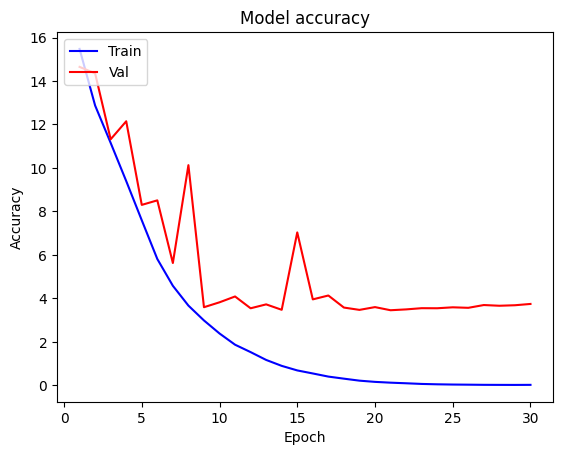

In [39]:
plotgraph(epochs, loss, val_loss)

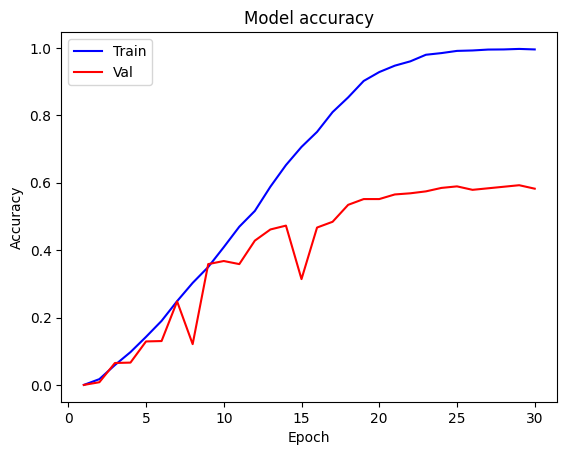

In [40]:
plotgraph(epochs, acc, val_acc)

In [41]:
minimum_val_loss = np.min(history.history['val_loss'])
best_model_index = np.where(history.history['val_loss'] == minimum_val_loss)[0][0]

best_loss = str(history.history['loss'][best_model_index])
best_acc = str(history.history['accuracy'][best_model_index])
best_val_loss = str(history.history['val_loss'][best_model_index])
best_val_acc = str(history.history['val_accuracy'][best_model_index])

In [42]:
with open('./history.txt', 'a') as f:
    new_data = '{},{},{},{},{},{},{},{},{},{}\n'.format(filepath,
                                                      optimizer_name,
                                                      str(RECORDS_COUNT),
                                                      e,
                                                      str(train_images.shape[0]),
                                                      str(valid_images.shape[0]),
                                                      best_loss,
                                                      best_acc,
                                                      best_val_loss,
                                                      best_val_acc)
    f.write(new_data)

In [43]:
model.save('./HTR_Using_CRNN/Model/Text_recognizer_Using_CRNN.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [44]:
act_model.save('./HTR_Using_CRNN/Model/Text_recognizer_Using_CRNN_act.h5')

In [ ]:
!pip install python-levenshtein

In [ ]:
import numpy as np
import random
from typing import Union
import os
import time
import string
import cv2
import difflib
from keras.models import load_model
import Levenshtein as lv
import keras.backend as K

In [ ]:
def process_image(img):
    """
    Converts image to shape (32, 128, 1) & normalize
    """
    w, h = img.shape

    # Aspect Ratio Calculation
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape

    img = img.astype('float32')

    # Converts each to (32, 128, 1)
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape

    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape

    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)

    img = cv2.subtract(255, img)

    img = np.expand_dims(img, axis=-1)  # Ensure the channel dimension is added

    # Normalize
    img = img / 255

    # Add batch dimension
    img = np.expand_dims(img, axis=0)

    return img


In [ ]:
max_label_len = 0

char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

# string.ascii_letters + string.digits (Chars & Digits)
# or
# "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

print(char_list, len(char_list))

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(char_list.index(chara))

    return dig_lst

In [ ]:
import difflib

def find_closest_medicine(user_input):
    closest_match = None
    highest_ratio = 0
    medicine_list = None

    with open("medicine_names.txt", "r") as file:
        medicine_list = file.read().splitlines()

    for medicine in medicine_list:
        similarity_ratio = difflib.SequenceMatcher(None, user_input.lower(), medicine.lower()).ratio()
        if similarity_ratio > highest_ratio:
            highest_ratio = similarity_ratio
            closest_match = medicine

    return closest_match, highest_ratio

In [ ]:
from keras.models import load_model
import cv2
import numpy as np
import Levenshtein as lv
import keras.backend as K
#from google.colab import files

# Load the saved model
model = load_model('./Text_recognizer_Using_CRNN_act.h5')

def predict_text(image_path, model):
    # Preprocess the input image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = process_image(image)
    # Perform prediction
    prediction = model.predict(img)
    # Perform CTC decoding to get the predicted text
    decoded = K.ctc_decode(prediction,
                           input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                           greedy=True)[0][0]
    out = K.get_value(decoded)
    predicted_text = ''
    for i, x in enumerate(out):
        for p in x:
            if int(p) != -1:
                predicted_text += char_list[int(p)]
    return predicted_text

# Example usage

#uploaded = files.upload()
#image_path = list(uploaded.keys())[0]

# predicted_text = predict_text(image_path, model)

# image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
# img = process_image(image)
# plt.imshow(img.reshape(32,128), cmap=plt.cm.gray)
# plt.show()
# print("Predicted Text:", predicted_text)

# closest_med, probability = find_closest_medicine(predicted_text)
# print(f"match: {closest_med} (Probability: {probability:.2f})")


In [ ]:
import difflib

def find_closest_medicine(user_input, medicine_list):
    closest_match = None
    highest_ratio = 0

    for medicine in medicine_list:
        similarity_ratio = difflib.SequenceMatcher(None, user_input.lower(), medicine.lower()).ratio()
        if similarity_ratio > highest_ratio:
            highest_ratio = similarity_ratio
            closest_match = medicine

    return closest_match, highest_ratio

# Example usage
if __name__ == "__main__":
    with open("medicine_names.txt", "r") as file:
        medicine_names = file.read().splitlines()

    user_input = input("Enter a medicine name: ")
    closest_med, probability = find_closest_medicine(user_input, medicine_names)

    print(f"Closest match: {closest_med} (Probability: {probability:.2f})")
